# Data Download and Exploration

This code means that the notebook will re-import your source code in `src` when it is edited (the default is not to re-import, because most modules are assumed not to change over time).  It's a good idea to include it in any exploratory notebook that uses `src` code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!ls

01_erh_download_and_explore_data.ipynb race2_2017.csv
README.md                              race_2017.csv
Visualization.ipynb                    tl_2017_53_puma10
cavinsNOTEBOOK.ipynb                   tl_2017_53_puma10.zip
main_table_2017.csv                    total_youth_2016.csv
opportunity_youth_2016.csv             total_youth_2017.csv
opportunity_youth_2017.csv             trend.ipynb


This snippet allows the notebook to import from the `src` module.  The directory structure looks like:

```
├── notebooks          <- Jupyter notebooks. Naming convention is a number (for ordering)
│   │                     followed by the topic of the notebook, e.g.
│   │                     01_data_collection_exploration.ipynb
│   └── exploratory    <- Raw, flow-of-consciousness, work-in-progress notebooks
│   └── report         <- Final summary notebook(s)
│
├── src                <- Source code for use in this project
│   ├── data           <- Scripts to download and query data
│   │   ├── sql        <- SQL scripts. Naming convention is a number (for ordering)
│   │   │                 followed by the topic of the script, e.g.
│   │   │                 03_create_pums_2017_table.sql
│   │   ├── data_collection.py
│   │   └── sql_utils.py
```

So we need to go up two "pardir"s (parent directories) to import the `src` code from this notebook.  You'll want to include this code at the top of any notebook that uses the `src` code.

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The code to download all of the data and load it into a SQL database is in the `data` module within the `src` module.  You'll only need to run `download_data_and_load_into_sql` one time for the duration of the project.

In [4]:
from src.data import data_collection

This line may take as long as 10-20 minutes depending on your network connection and computer specs

In [5]:
#data_collection.download_data_and_load_into_sql()

Now it's time to explore the data!

In [6]:
import psycopg2
import pandas as pd
import numpy as np
from tabula import read_pdf
pd.set_option('max_colwidth', 80)

In [7]:
#DBNAME = "opportunity_youth"

In [8]:
#conn = psycopg2.connect(dbname=DBNAME)

In [9]:
import src.create_tables as FF
df=FF.create_df()

In [10]:
total_youth_2017=FF.create_total_youth_2017(df)
total_youth_2017

,%16-18,16-18,%19-21,19-21,%22-24,22-24,%Total,Total
youthtype,,,,,,,,
Total,100,30141,100,25486,100,30256,100,85883
Opportunity Youth,6,1815,15,3902,16,4897,12,10614
Working without Diploma,14,4377,6,1630,5,1705,8,7712
Not Opportunity Youth,79,23949,78,19954,78,23654,78,67557


In [11]:
opportunity_youth_2017=FF.create_total_youth_2017(df)
opportunity_youth_2017

,%16-18,16-18,%19-21,19-21,%22-24,22-24,%Total,Total
youthtype,,,,,,,,
Total,100,30141,100,25486,100,30256,100,85883
Opportunity Youth,6,1815,15,3902,16,4897,12,10614
Working without Diploma,14,4377,6,1630,5,1705,8,7712
Not Opportunity Youth,79,23949,78,19954,78,23654,78,67557


Notice the `LIMIT 10` above.  These tables have a large amount of data in them and **your goal is to use SQL to create your main query, not Pandas**.  Pandas can technically do everything that you need to do, but it will be much slower and more inefficient.  Nevertheless, Pandas is still a useful tool for exploring the data and getting a basic sense of what you're looking at.

In [12]:
df_2016=FF.create_basetable_2016()

In [13]:
total_youth_2016=FF.create_total_youth_2016(df_2016)
total_youth_2016

,%16-18,16-18,%19-21,19-21,%22-24,22-24,%Total,Total
Total,100,50053,100,41651,100,48031,100,139735
Opportunity Youth,5,2805,17,7284,18,8728,13,18817
Working without Diploma,1,587,4,2049,5,2877,3,5513
Not Opportunity Youth,93,46661,77,32318,75,36426,82,115405


In [14]:
opportunity_youth_2016=FF.create_opportunity_youth_2016(df_2016)
opportunity_youth_2016

,%16-18,16-18,%19-21,19-21,%22-24,22-24,%Total,Total
Total,100,2805,100,7284,100,8728,100,18817
No Diploma,57,1610,28,2048,22,1981,29,5639
HS Diploma or GED,35,985,45,3349,35,3067,39,7401
"Some College, No Degree",6,179,22,1666,20,1763,19,3608
Degree (Associate or Higher),1,31,3,221,21,1917,11,2169


Make sure you close the DB connection when you are done using it

In [94]:
df=FF.create_df()
race_2017=FF.create_race_2017(df)
race_2017.reset_index()
race_2017

,Rate of OY %,Total,Proportion of OY %,Opportunity Youth
race,,,,
American Indian\Alaska Native,40,851,3,347
Asian,8,13239,11,1189
Black\African American,15,8630,12,1315
Hawaiian and Other Pacific Islander,19,1814,3,360
Hispanic,13,15942,20,2133
Some other Race alone,5,295,0,16
Two or More Races,13,6353,8,862
White,11,38759,41,4392
Total,12,85883,100,10614


In [132]:
race_2016=FF.create_race_2016()
race_2016

,Rate of OY %,Total,Proportion of OY %,Opportunity Youth
Total,13,139735,100,18817
American Indian\Alaska Native,31,1242,2,387
Hawaiian and Other Pacific Islander,23,1884,2,439
Black\African American,19,14339,14,2791
Hispanic,17,11490,10,2008
Some other Race alone,17,6473,5,1112
Two or More Races,12,12368,8,1534
White,12,69050,45,8547
Asian,8,22889,10,1999


In [103]:
race_youthtype_2017=FF.create_race2_2017(df)
race_youthtype_2017

,%Black/African American,Black/African American,%Hispanic,Hispanic,%Other Races,Other Races,%White,White,%Total,Total
youthtype,,,,,,,,,,
Not Opportunity Youth,78,6744,71,11355,82,18658,79,30800,78,67557
Opportunity Youth,15,1315,13,2133,12,2774,11,4392,12,10614
Working without Diploma,6,571,15,2454,4,1120,9,3567,8,7712
Total,100,8630,100,15942,100,22552,100,38759,100,85883


In [25]:
import src.visualization_pj1 as VSZ
datafiles=VSZ.pull_data()

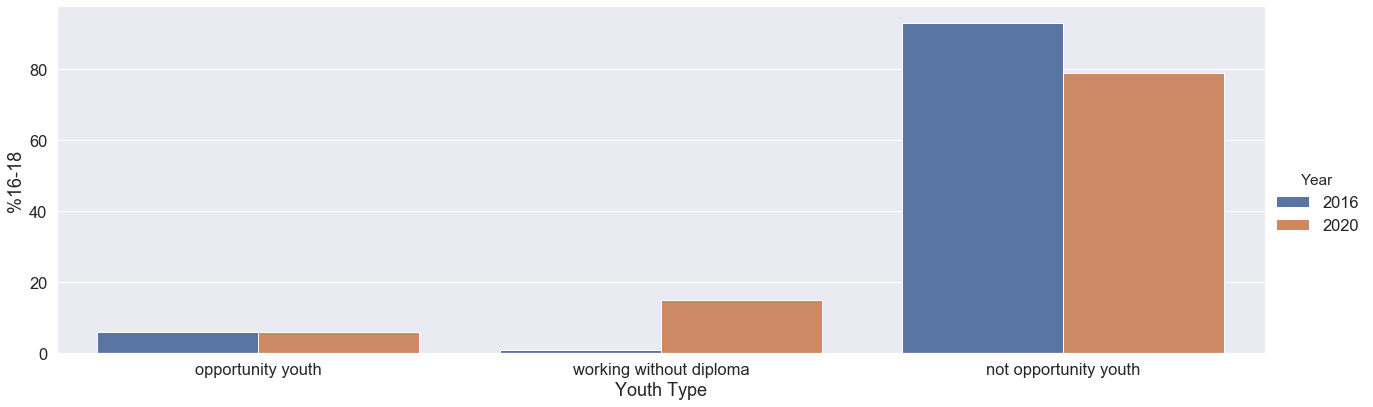

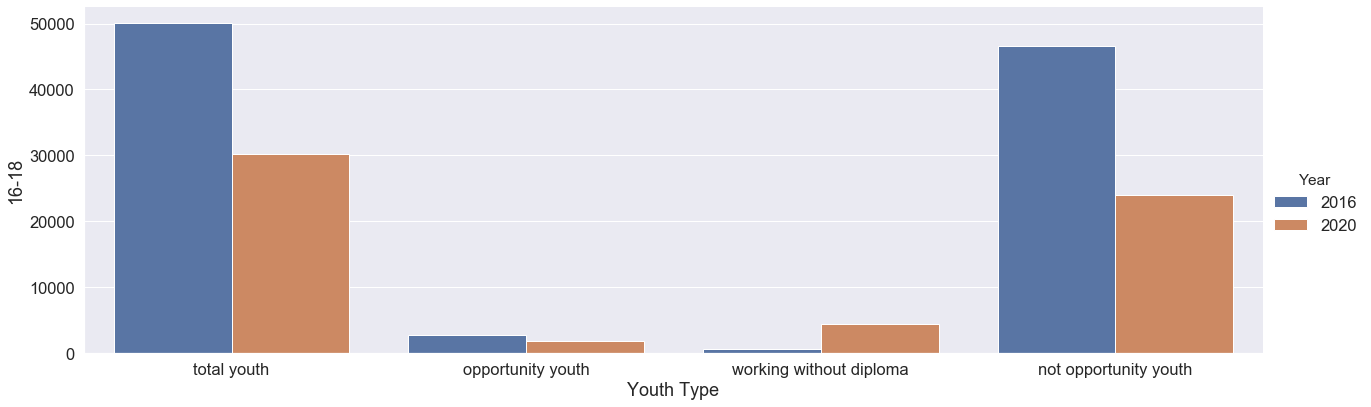

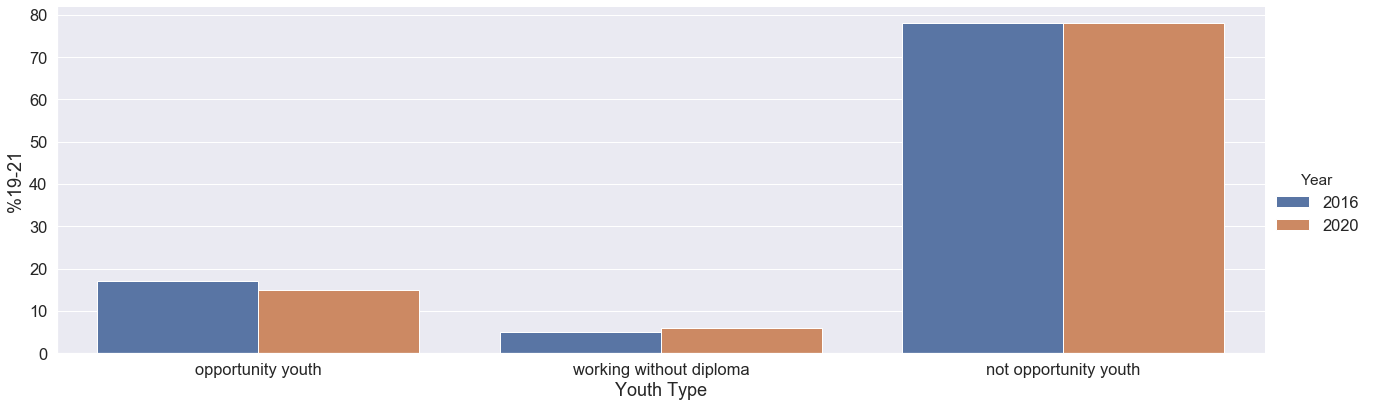

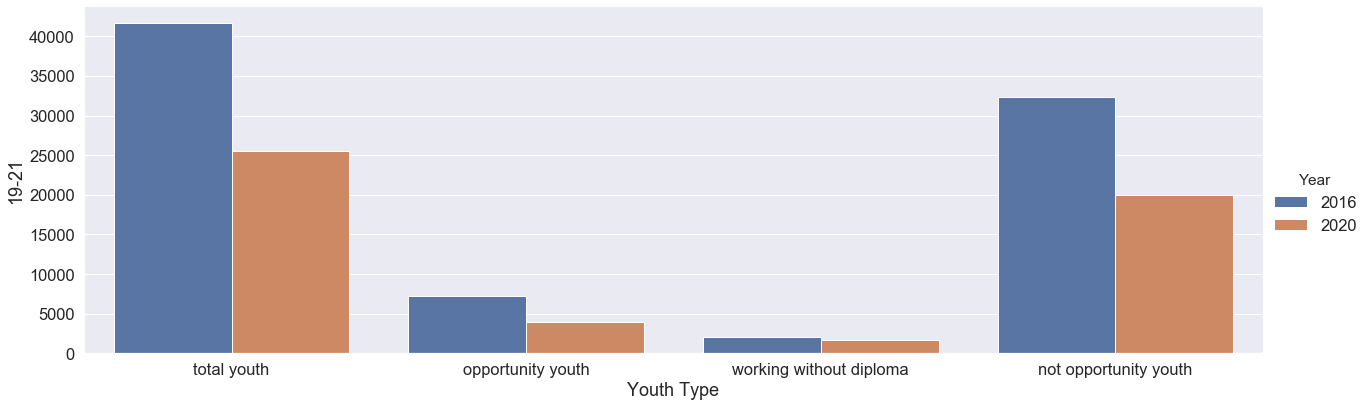

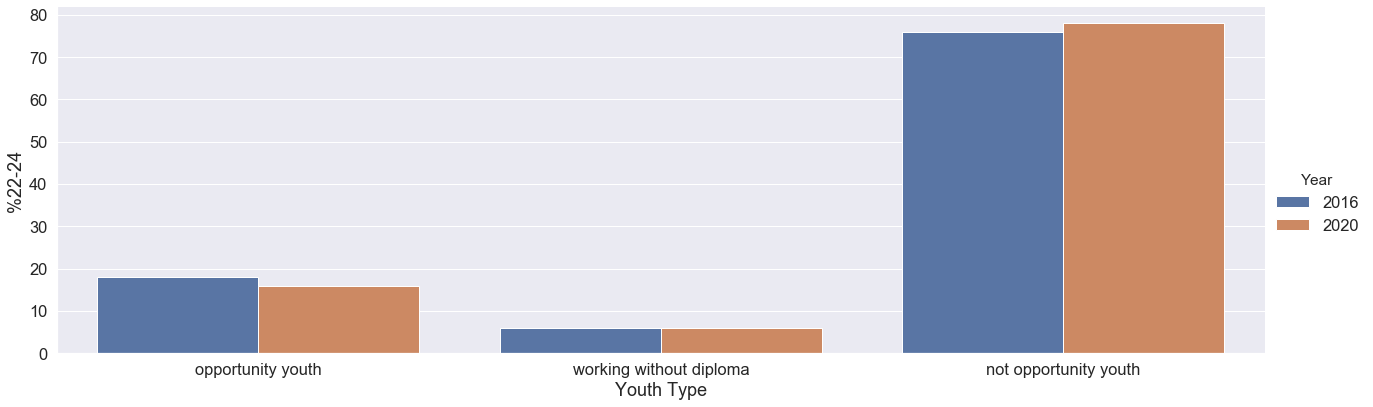

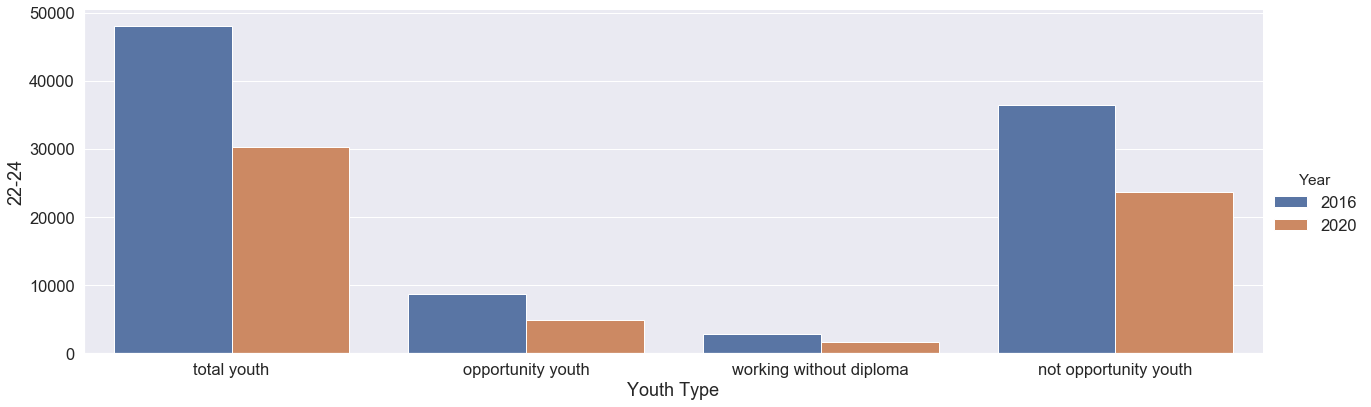

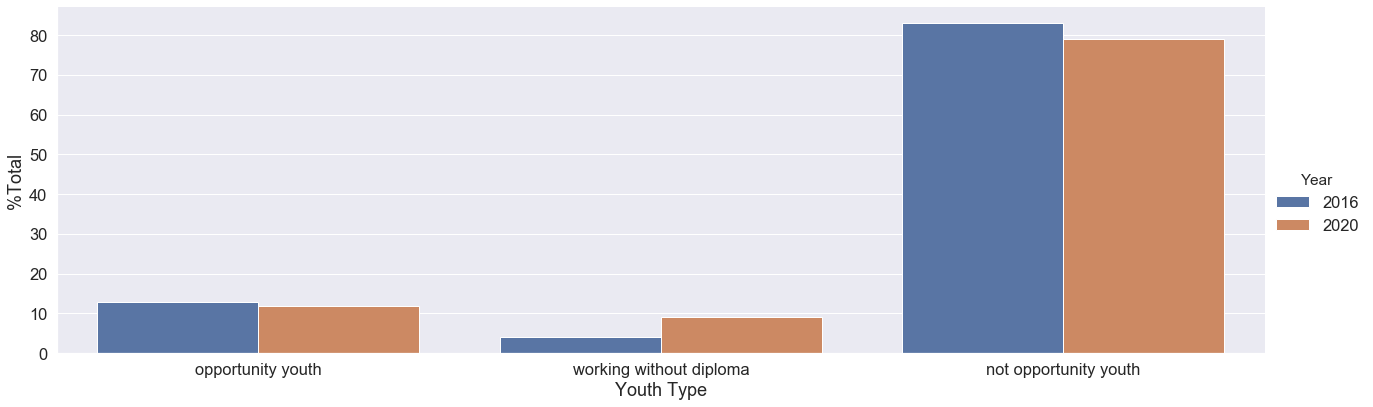

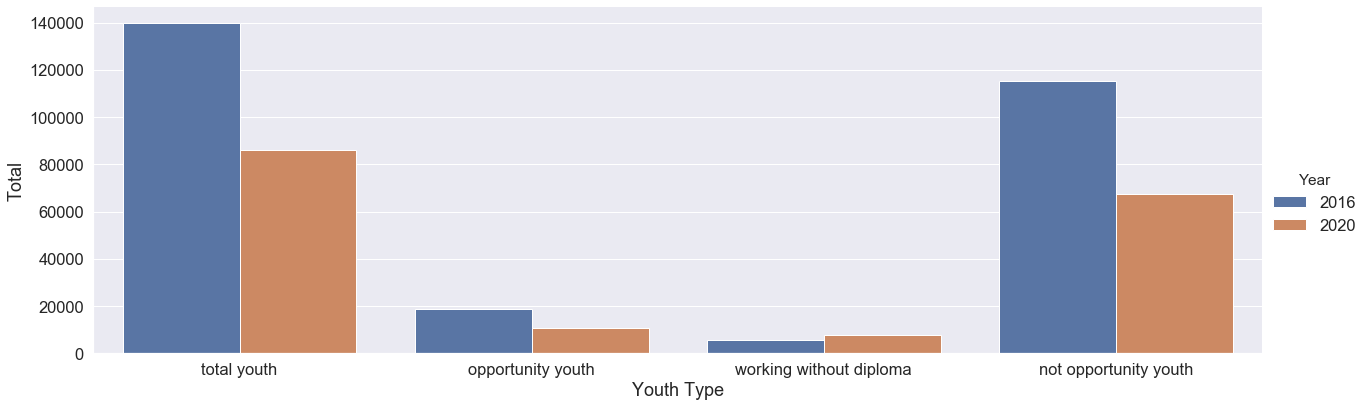

In [29]:
createbar_201=VSZ.create_trend_bar_age(datafiles)

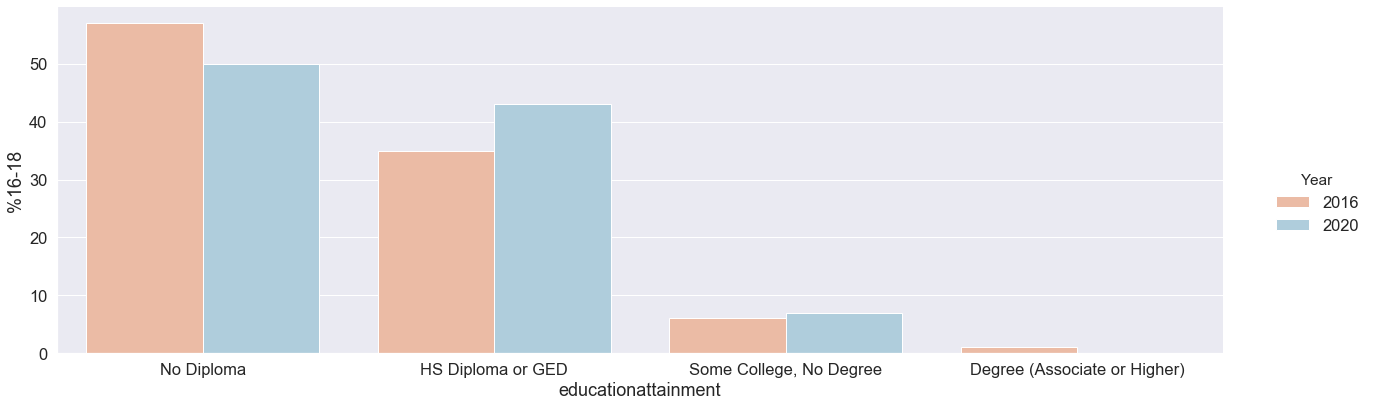

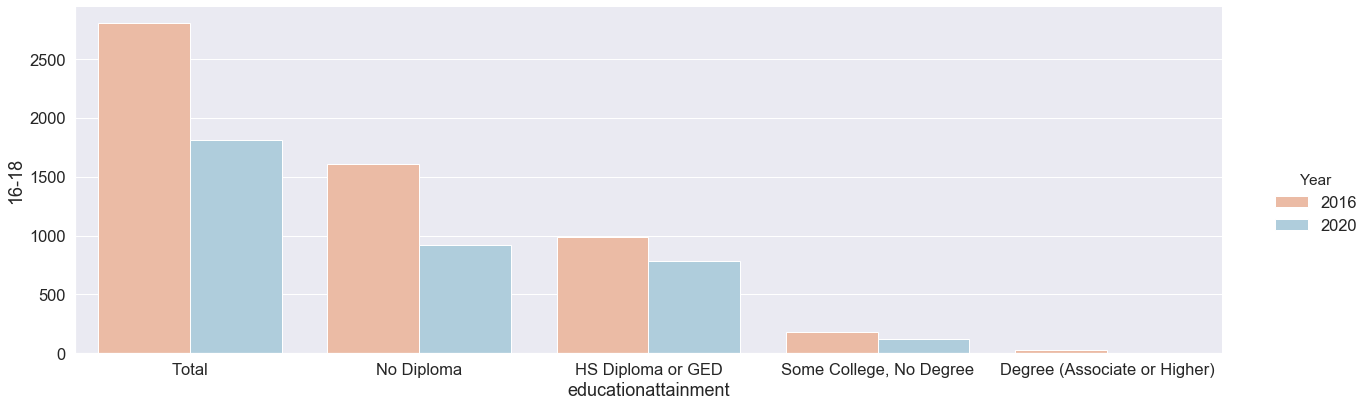

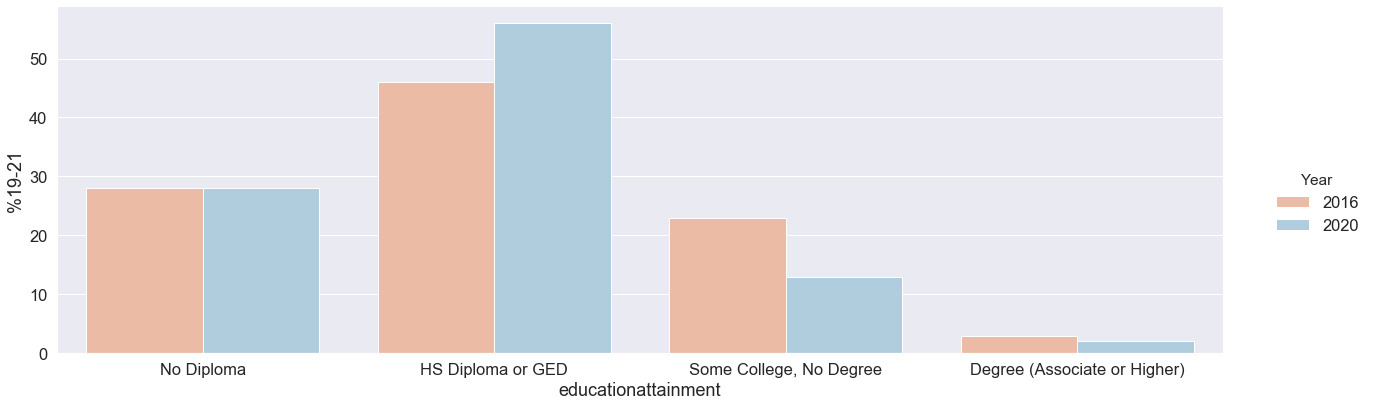

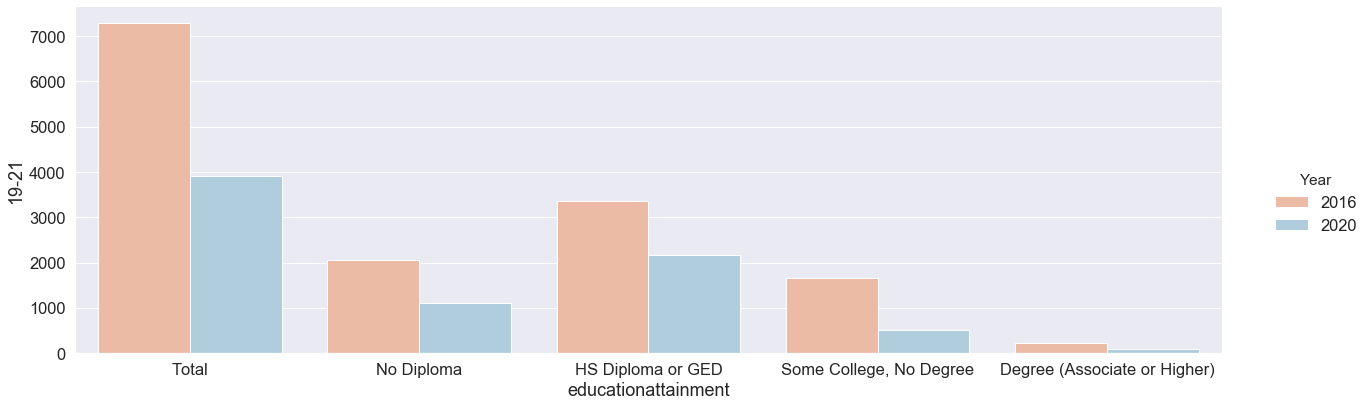

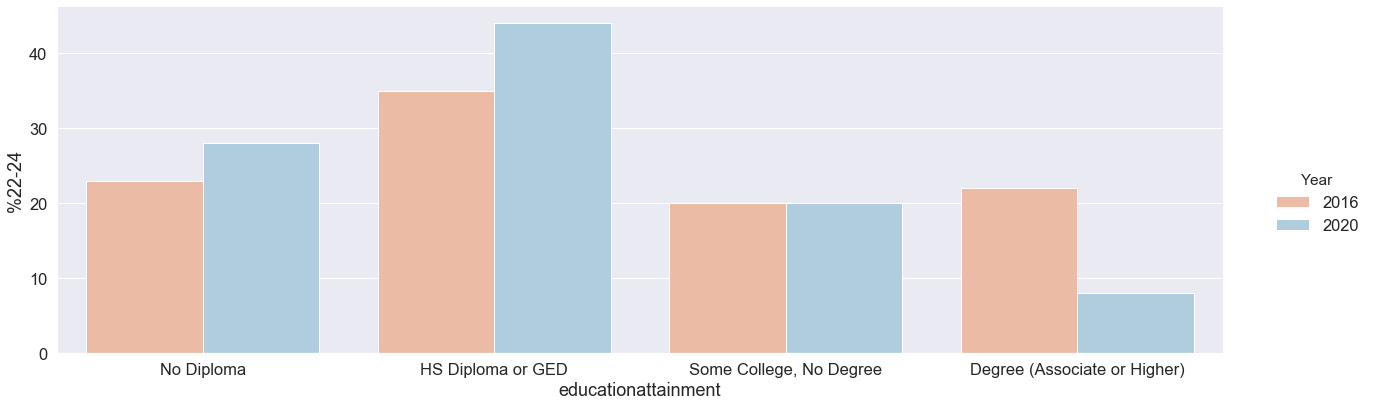

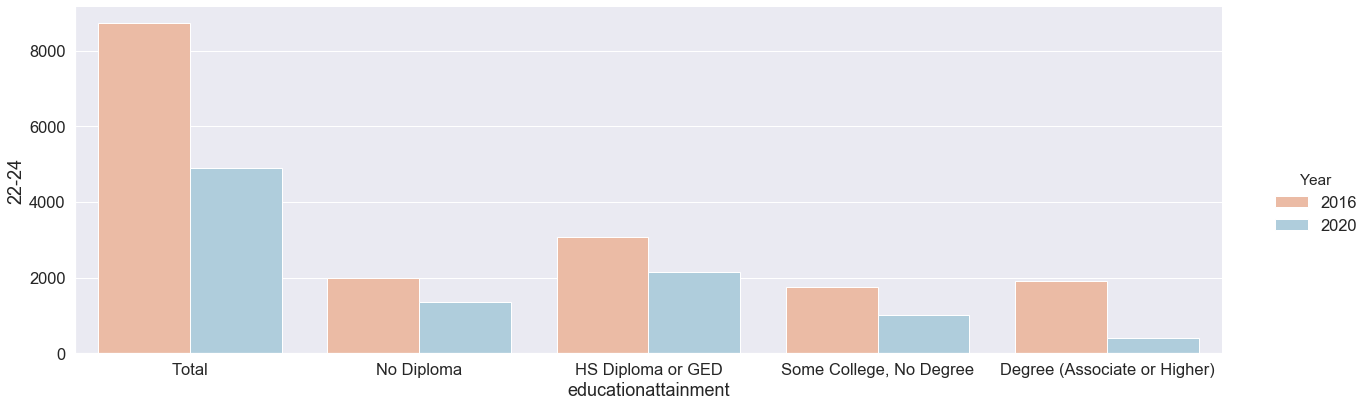

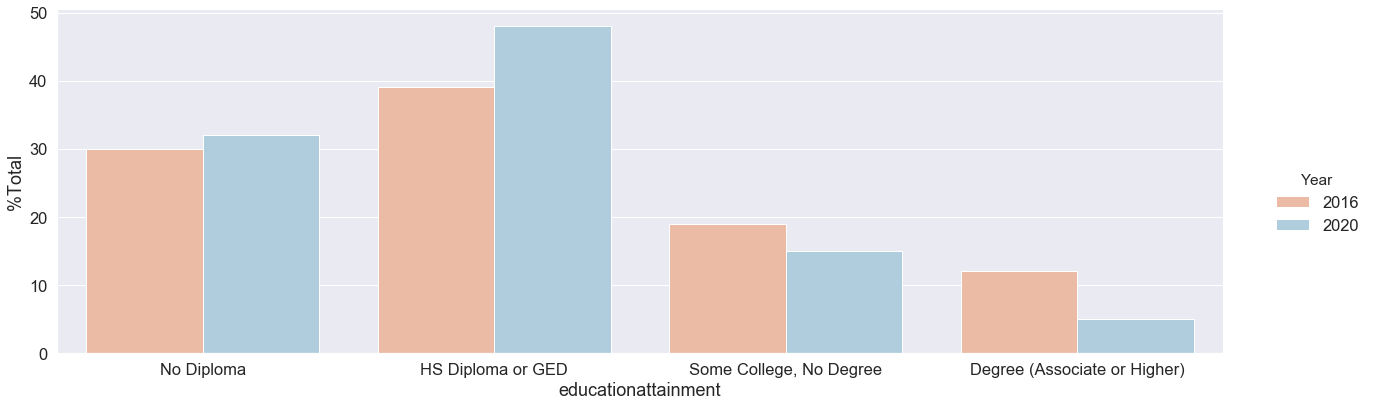

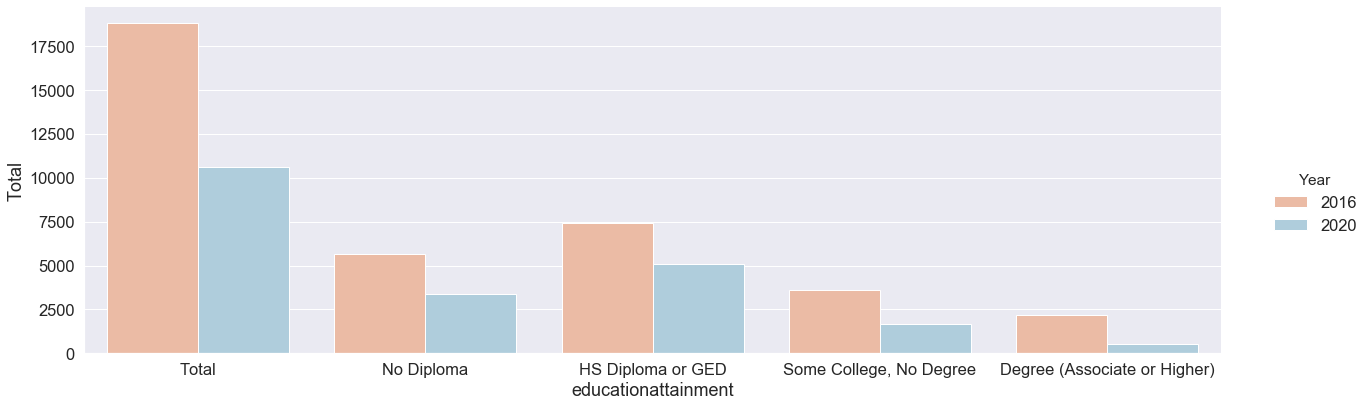

In [30]:
createbar_degree_1620=VSZ.create_trend_bar_degree(datafiles)
createbar_degree_1620

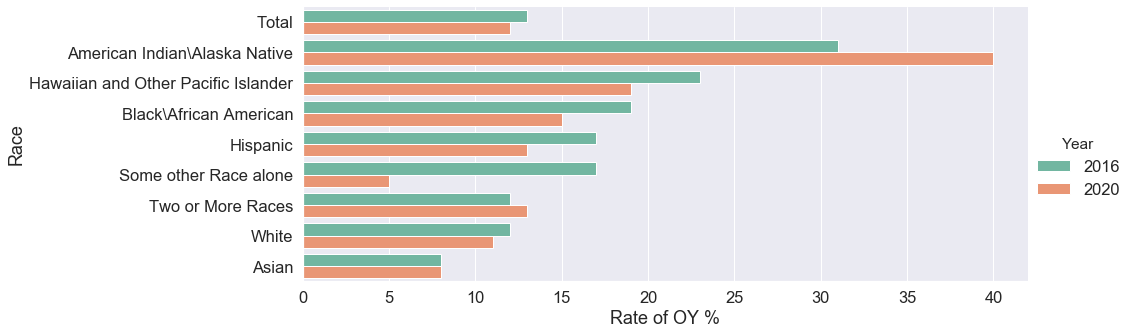

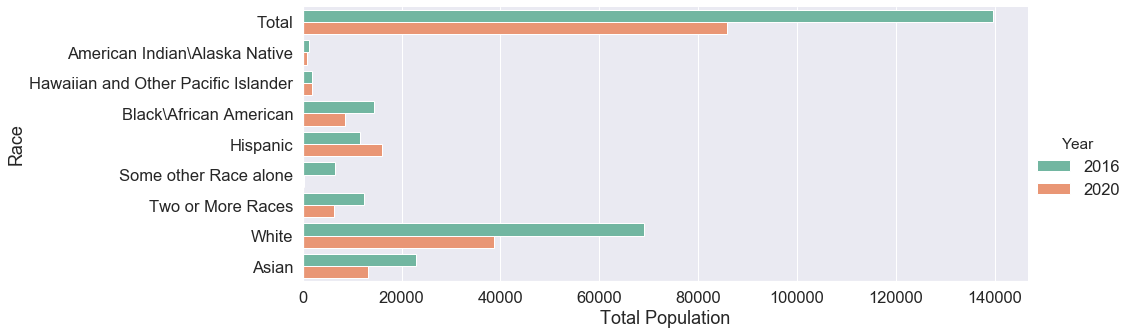

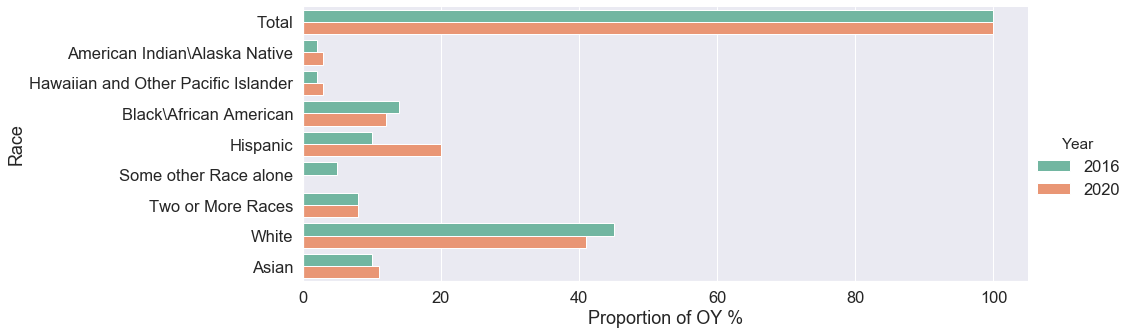

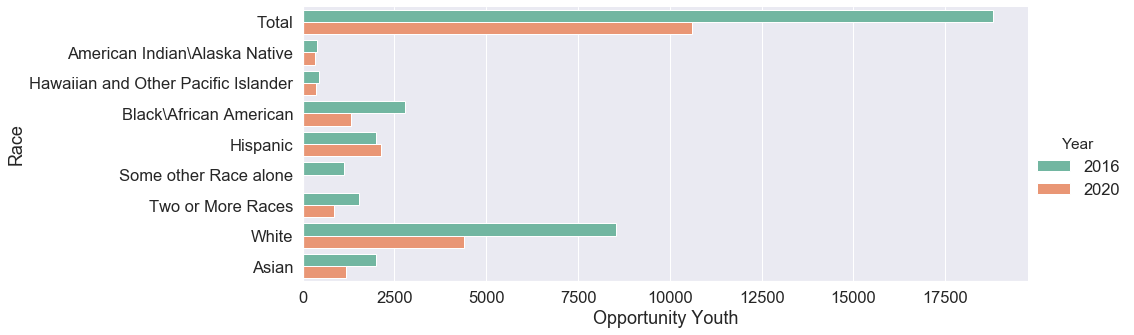

In [143]:
race_bar =VSZ.create_race_bar(race_2016, race_2017)